### 1. 모듈 임포트

In [ ]:
import numpy as np  # 수치 계산을 위한 라이브러리
import matplotlib.pyplot as plt # 데이터 시각화를 위한 라이브러리
import torch # PyTorch 라이브러리
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 함수
from torchvision import transforms, datasets # 이미지 변환 및 데이터셋

### 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print('파이토치 버전 :', torch.__version__, '사용 디바이스 :', device)

BATCH_SIZE = 32 # 배치 크기
EPOCHS = 10 # 학습 반복 횟수

파이토치 버전 : 2.6.0+cu124 사용 디바이스 : cuda


### 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기)

In [4]:
train_dataset = datasets.MNIST(
    root='../data/MNIST', # 데이터셋 저장 경로
    train=True, # 학습용 데이터셋 여부
    download = True, # 데이터셋 다운로드 여부
    transform=transforms.ToTensor() # 이미지 데이터를 텐서로 변환
)

test_dataset = datasets.MNIST(
    root='../data/MNIST', # 데이터셋 저장 경로
    train=False, # 테스트용 데이터셋 여부
    download = True, # 데이터셋 다운로드 여부
    transform=transforms.ToTensor() # 이미지 데이터를 텐서로 변환
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, # 학습용 데이터셋
    batch_size=BATCH_SIZE, # 배치 크기
    shuffle=True # 매 epoch마다 데이터 섞기
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, # 테스트용 데이터셋
    batch_size=BATCH_SIZE, # 배치 크기
    shuffle=False # 테스트 데이터는 섞지 않음
)

### 4. 데이터 확인하기

X_train 크기: torch.Size([32, 1, 28, 28]) X_train 타입: torch.FloatTensor
y_train 크기: torch.Size([32]) y_train 타입: torch.LongTensor


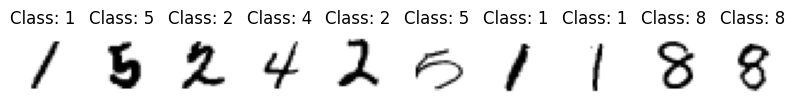

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train 크기:', X_train.size(), 'X_train 타입:', X_train.type())
    print('y_train 크기:', y_train.size(), 'y_train 타입:', y_train.type())
    break   # 첫 번째 배치만 확인

pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize)) # 그래프 크기 설정

for i in range(10):
    plt.subplot(1, 10, i + 1) # 1행 10열의 서브플롯 생성
    plt.axis('off') # 축 숨기기
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r') # 이미지 출력
    plt.title('Class: ' + str(y_train[i].item())) # 클래스 레이블 출력

### 5. Multi Layer Perceptron (MLP) 모델 설계하기

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512) # 첫 번째 완전 연결층
        self.fc2 = nn.Linear(512, 256)     # 두 번째 완전 연결층
        self.fc3 = nn.Linear(256, 10)      # 세 번째 완전 연결층 (출력층)

        self.dropout_prob = 0.5  # 드롭아웃 확률 설정

        self.batch_norm1 = nn.BatchNorm1d(512)  # 첫 번째 층에 대한 배치 정규화
        self.batch_norm2 = nn.BatchNorm1d(256)  # 두 번째 층에 대한 배치 정규화

    def forward(self, x):
        x = x.view(-1, 28 * 28)            # 입력 이미지를 1차원 벡터로 변환
        x = F.relu(self.batch_norm1(self.fc1(x)))  # 첫 번째 층 + 배치 정규화 + ReLU 활성화
        x = F.dropout(x, p=self.dropout_prob, training=self.training)  # 드롭아웃 적용
        
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)  # 드롭아웃 적용

        x = self.fc3(x)                    # 출력층
        x = F.log_softmax(x, dim=1)         # 소프트맥스 함수 적용

        return x

### 6. Optimizer, Objective Function 설정하기

In [7]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight)  # He 초기화
        # m.bias.data.fill_(0.01)          # 편향 초기화

model = Net().to(device) # 모델을 디바이스로 이동
model.apply(weight_init)  # 가중치 초기화 함수 적용

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam 옵티마이저
criterion = nn.CrossEntropyLoss() # 교차 엔트로피 손실 함수

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### 7. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

In [8]:
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 모드로 설정
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device) # 이미지 데이터를 디바이스로 이동
        label = label.to(device) # 레이블 데이터를 디바이스로 이동
        optimizer.zero_grad() # 기울기 초기화
        output = model(image) # 모델에 이미지 입력하여 출력 계산
        losss = criterion(output, label) # 손실 계산
        losss.backward() # 역전파로 기울기 계산
        optimizer.step() # 가중치 업데이트

        if batch_idx % log_interval == 0:   # 일정 간격마다 로그 출력
            print('학습 Epoch: {} [{}/{} ({:.0f}%)]\t학습 손실(Loss) : {:.6f}'.format(
                epoch, batch_idx * len(image), # 현재까지 학습한 데이터 수
                len(train_loader.dataset), # 전체 학습 데이터 수
                100. * batch_idx / len(train_loader), # 학습 진행률
                losss.item() # 현재 배치의 손실 값
            ))


### 8. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [9]:
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 모드로 설정
    test_loss = 0   # 테스트 손실 초기화
    correct = 0  # 맞춘 개수 초기화

    with torch.no_grad(): # 평가 시에는 기울기 계산하지 않음
        for image, label in test_loader:
            image = image.to(device) # 이미지 데이터를 디바이스로 이동
            label = label.to(device) # 레이블 데이터를 디바이스로 이동
            output = model(image) # 모델에 이미지 입력하여 출력 계산
            test_loss += criterion(output, label).item() # 배치 손실 누적
            prediction = output.argmax(dim=1, keepdim=True) # 가장 높은 확률의 클래스 선택
            correct += prediction.eq(label.view_as(prediction)).sum().item() # 정답과 비교하여 맞춘 개수 누적

    test_loss /= len(test_loader.dataset) # 평균 손실 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산    

    return test_loss, test_accuracy # 평가 손실과 정확도 반환

### 9. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200) # 모델 학습
    test_loss, test_accuracy = evaluate(model, test_loader) # 모델 평가
    print("\n-------------------------------------------------------------------------------------")
    print(f"Epoch {epoch}:      Test Loss: {test_loss:.4f},     Test Accuracy: {test_accuracy:.2f}%")
    print("-------------------------------------------------------------------------------------\n")

학습 Epoch: 1 [0/60000 (0%)]	학습 손실(Loss) : 3.381463
학습 Epoch: 1 [6400/60000 (11%)]	학습 손실(Loss) : 0.182580
학습 Epoch: 1 [12800/60000 (21%)]	학습 손실(Loss) : 0.352283
학습 Epoch: 1 [19200/60000 (32%)]	학습 손실(Loss) : 1.082338
학습 Epoch: 1 [25600/60000 (43%)]	학습 손실(Loss) : 0.219280
학습 Epoch: 1 [32000/60000 (53%)]	학습 손실(Loss) : 0.765841
학습 Epoch: 1 [38400/60000 (64%)]	학습 손실(Loss) : 0.426125
학습 Epoch: 1 [44800/60000 (75%)]	학습 손실(Loss) : 0.248826
학습 Epoch: 1 [51200/60000 (85%)]	학습 손실(Loss) : 0.240209
학습 Epoch: 1 [57600/60000 (96%)]	학습 손실(Loss) : 0.478967

-------------------------------------------------------------------------------------
Epoch 1:      Test Loss: 0.0040,     Test Accuracy: 96.19%
-------------------------------------------------------------------------------------

학습 Epoch: 2 [0/60000 (0%)]	학습 손실(Loss) : 0.083711
학습 Epoch: 2 [6400/60000 (11%)]	학습 손실(Loss) : 0.315221
학습 Epoch: 2 [12800/60000 (21%)]	학습 손실(Loss) : 0.139232
학습 Epoch: 2 [19200/60000 (32%)]	학습 손실(Loss) : 0.115282
학습 Epoch: